
--- Iniciando Geração de Gráficos de Insights Adicionais (para 2 classes com cores customizadas) ---
Base de dados para visualização carregada: 5293 linhas.
Info VIZ: Usando ponto de corte fixo para salários: 9000.00
       Salários <= 9000.00 serão 'Salário Baixo' (Salário Baixo)
       Salários >  9000.00 serão 'Salário Alto' (Salário Alto)
Coluna alvo 'faixa_salarial_agrupada_2cat_fixed' criada para visualização.
Contagem das faixas salariais em df_main_viz:
faixa_salarial_agrupada_2cat_fixed
Salário Baixo    3294
Salário Alto     1459
Name: count, dtype: int64


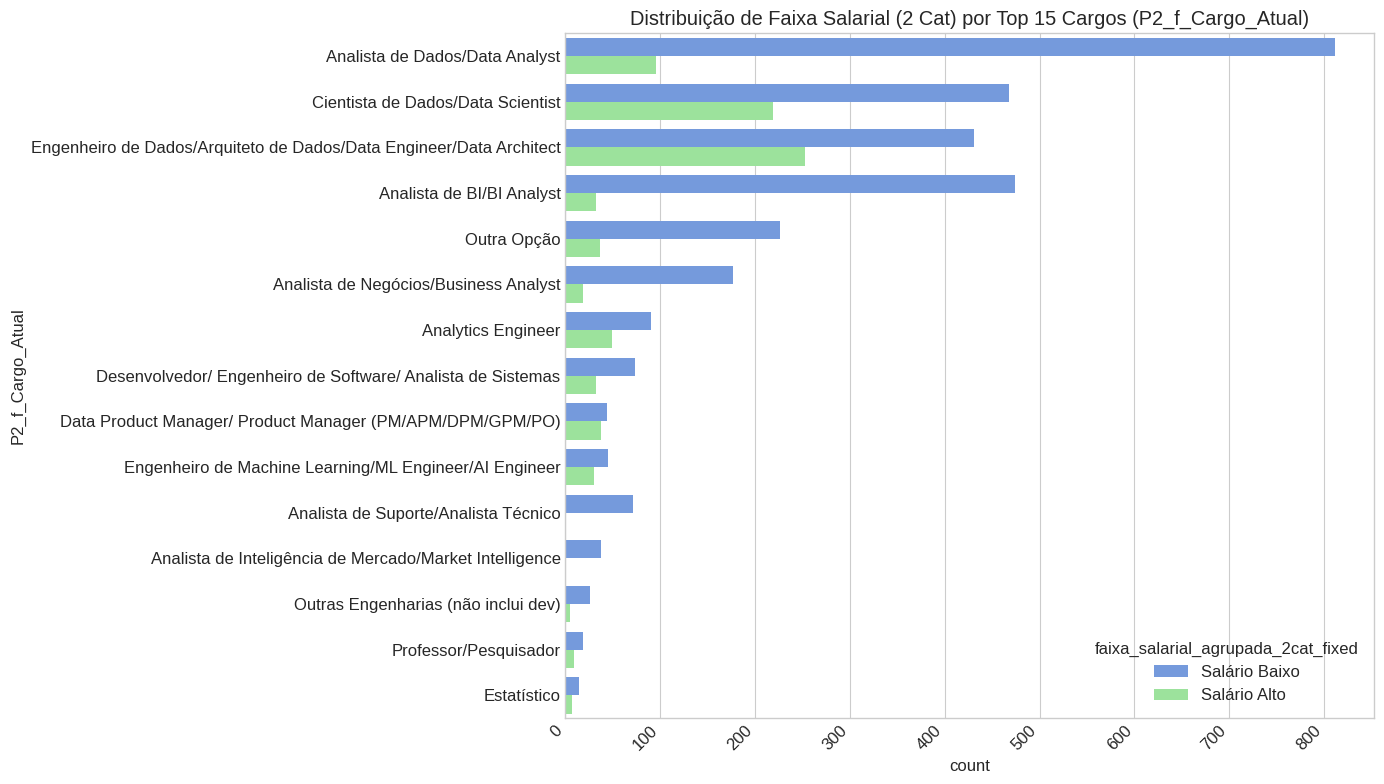

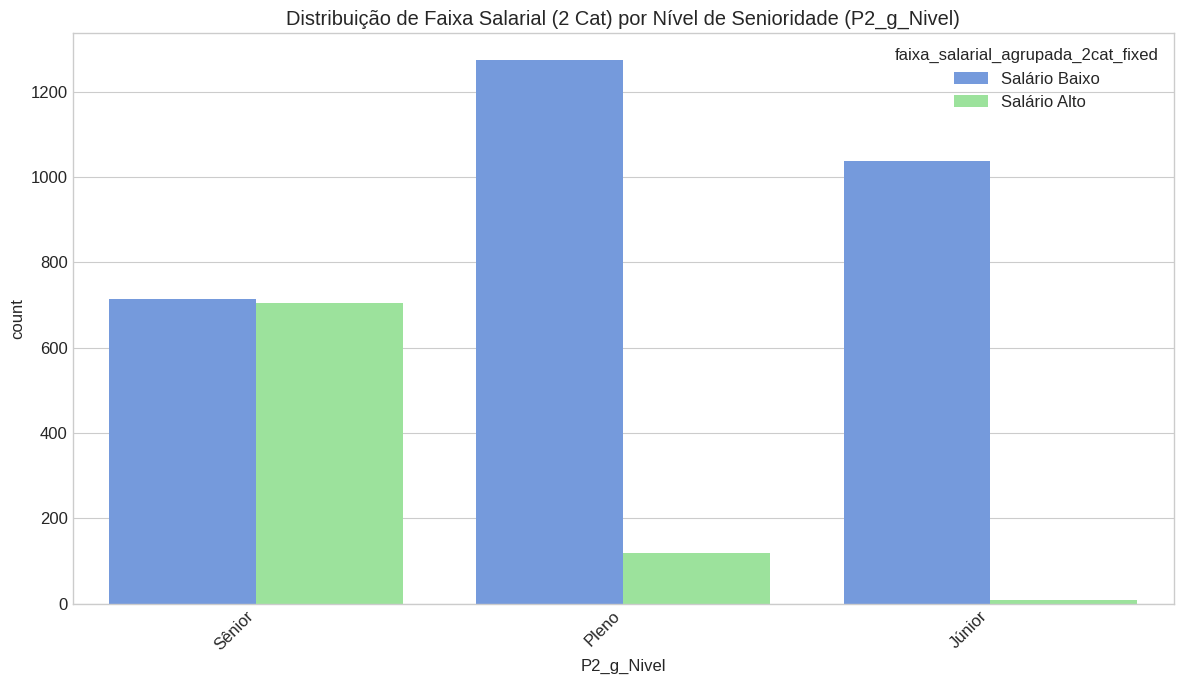

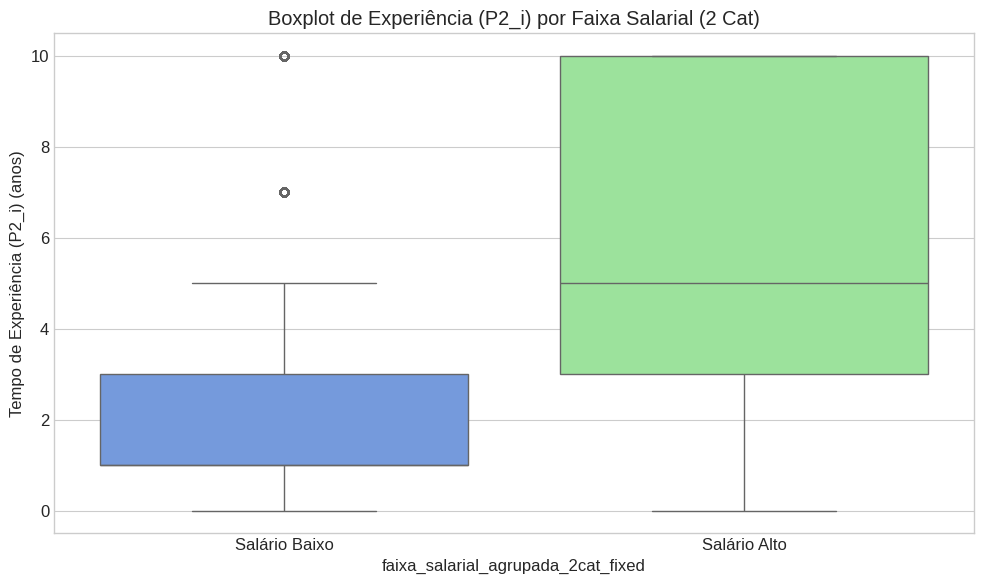

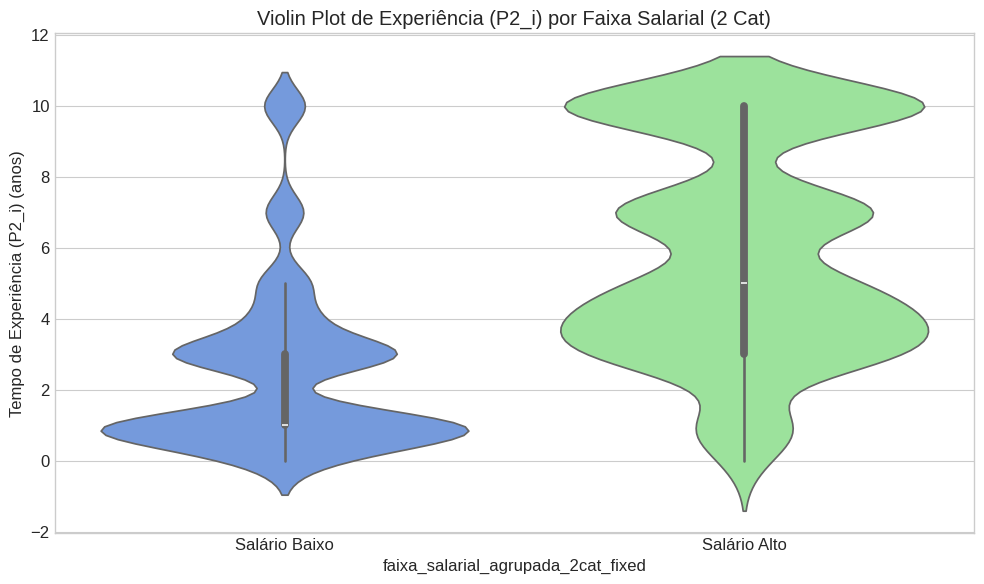


Seções de gráficos 3D foram removidas do script.

--- Geração de Gráficos de Insights Adicionais Concluída ---
Gráficos 2D (se gerados) salvos em: /content/visualizacoes_classificacao_salario_v7_rfecv


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import re # Certifique-se de que re está importado se clean_col_name precisar

# --- Funções de pré-processamento ---
# (Mantidas como no seu script original)
def clean_col_name(col_name):
    """Limpa o nome da coluna para ser compatível com LightGBM."""
    original_input = col_name
    if isinstance(col_name, tuple):
        col_name = "_".join(str(item).strip() for item in col_name)
    elif not isinstance(col_name, str):
        col_name = str(col_name)
    col_name = re.sub(r'[^\w\s-]', '', col_name).strip()
    col_name = re.sub(r'[-\s]+', '_', col_name)
    col_name = re.sub(r"_+", "_", col_name)
    col_name = col_name.strip("_")
    if not col_name: return f"col_limpa_vazia_{hash(original_input)}"
    if col_name and col_name[0].isdigit(): col_name = "_" + col_name
    return col_name

def extract_salary_lower_bound(salary_range_str):
    """Extrai o limite inferior numérico de uma string de faixa salarial."""
    if pd.isna(salary_range_str): return np.nan
    s = str(salary_range_str).lower().replace('r$', '').replace('.', '').replace('/mês', '').strip()
    match_de_a = re.search(r'de\s*(\d+)\s*a\s*(\d+)', s)
    if match_de_a: return float(match_de_a.group(1))
    match_acima_de = re.search(r'acima de\s*(\d+)', s)
    if match_acima_de: return float(match_acima_de.group(1))
    match_menos_de = re.search(r'menos de\s*(\d+)', s)
    if match_menos_de: return 0
    match_so_numeros = re.findall(r'\d+', s)
    if match_so_numeros: return float(match_so_numeros[0])
    return np.nan

def clean_experience_to_numeric(exp_val):
    """Converte strings de experiência para valores numéricos."""
    if pd.isna(exp_val):
        return np.nan
    s = str(exp_val).lower().strip()
    if 'menos de 1 ano' in s or 'menos de um ano' in s or '< 1 ano' in s:
        return 0.5
    if 'não tenho experiência' in s or 'sem experiência' in s:
        return 0
    numbers = re.findall(r'\d+\.?\d*', s)
    if numbers:
        return float(numbers[0])
    return np.nan

# --- Fim das Funções de pré-processamento ---

print("\n--- Iniciando Geração de Gráficos de Insights Adicionais (para 2 classes com cores customizadas) ---")

output_dir = 'visualizacoes_classificacao_salario_v7_rfecv'
os.makedirs(output_dir, exist_ok=True)

file_path = "Main_database (2).xlsx"
if not os.path.exists(file_path):
    print(f"ERRO: Arquivo de dados '{file_path}' não encontrado. Ajuste o caminho.")
else:
    df_main_viz = pd.read_excel(file_path)
    original_columns_viz = df_main_viz.columns.tolist()
    df_main_viz.columns = [clean_col_name(col) for col in original_columns_viz]
    print(f"Base de dados para visualização carregada: {df_main_viz.shape[0]} linhas.")

    col_mapping_viz = {
        "target_original_salary_range": "P2_h",
        "tempo_experiencia_P2i": "P2_i",
        "nivel_senioridade_P2g": "P2_g_Nivel",
        "cargo_atual_P2f": "P2_f_Cargo_Atual"
    }

    target_col_processed_name = "faixa_salarial_agrupada_2cat_fixed"

    original_salary_col_name_viz = col_mapping_viz.get("target_original_salary_range")

    if not original_salary_col_name_viz or original_salary_col_name_viz not in df_main_viz.columns:
        print(f"ERRO: Coluna original de salário '{original_salary_col_name_viz}' não mapeada ou não encontrada.")
    else:
        df_main_viz.dropna(subset=[original_salary_col_name_viz], inplace=True)
        df_main_viz['salary_numeric_lower_bound'] = df_main_viz[original_salary_col_name_viz].apply(extract_salary_lower_bound)
        df_main_viz.dropna(subset=['salary_numeric_lower_bound'], inplace=True)

        if df_main_viz.empty:
            print("DataFrame vazio após processar salary_numeric_lower_bound.")
        else:
            salary_group_labels_2cat = ["Salário Baixo", "Salário Alto"]
            min_salary_viz = df_main_viz['salary_numeric_lower_bound'].min()
            max_salary_viz = df_main_viz['salary_numeric_lower_bound'].max()

            if min_salary_viz == max_salary_viz:
                print(f"Aviso VIZ: Todos os valores de 'salary_numeric_lower_bound' são iguais ({min_salary_viz}). Apenas uma categoria será criada.")
                df_main_viz[target_col_processed_name] = salary_group_labels_2cat[0]
            else:
                # !! IMPORTANTE !! AJUSTE ESTE VALOR PARA SER O MESMO DO SEU SCRIPT DE TREINAMENTO
                point_of_cut_fixed_viz = 9000.0 # Exemplo, ajuste conforme seu treino!

                print(f"Info VIZ: Usando ponto de corte fixo para salários: {point_of_cut_fixed_viz:.2f}")
                print(f"       Salários <= {point_of_cut_fixed_viz:.2f} serão '{salary_group_labels_2cat[0]}' (Salário Baixo)")
                print(f"       Salários >  {point_of_cut_fixed_viz:.2f} serão '{salary_group_labels_2cat[1]}' (Salário Alto)")

                final_bins_viz = []
                final_labels_viz = []

                if point_of_cut_fixed_viz <= min_salary_viz:
                    final_bins_viz = [min_salary_viz, max_salary_viz]
                    final_labels_viz = [salary_group_labels_2cat[1]]
                elif point_of_cut_fixed_viz >= max_salary_viz:
                    final_bins_viz = [min_salary_viz, max_salary_viz]
                    final_labels_viz = [salary_group_labels_2cat[0]]
                else:
                    final_bins_viz = [min_salary_viz, point_of_cut_fixed_viz, max_salary_viz]
                    final_labels_viz = salary_group_labels_2cat

                unique_sorted_bins_viz = sorted(list(set(final_bins_viz)))

                if len(unique_sorted_bins_viz) < 2:
                    print(f"Erro VIZ: Não foi possível definir pelo menos 2 bins únicos ({unique_sorted_bins_viz}).")
                    df_main_viz[target_col_processed_name] = "Categoria Única"
                elif len(unique_sorted_bins_viz) == 2 and len(final_labels_viz) == 2:
                    print(f"Aviso VIZ: Ponto de corte resultou em 2 bins efetivos, criando 1 categoria.")
                    if point_of_cut_fixed_viz <= min_salary_viz + 1e-9: final_labels_viz = [salary_group_labels_2cat[1]]
                    else: final_labels_viz = [salary_group_labels_2cat[0]]

                try:
                    df_main_viz[target_col_processed_name] = pd.cut(
                        df_main_viz['salary_numeric_lower_bound'],
                        bins=unique_sorted_bins_viz,
                        labels=final_labels_viz,
                        include_lowest=True,
                        duplicates='drop'
                    )
                except Exception as e_cut_viz:
                    print(f"Erro VIZ durante pd.cut: {e_cut_viz}. Tentando pd.qcut como fallback.")
                    try:
                        df_main_viz[target_col_processed_name] = pd.qcut(df_main_viz['salary_numeric_lower_bound'], q=2, labels=salary_group_labels_2cat, duplicates='drop')
                    except:
                        print("Fallback VIZ com qcut falhou. Atribuindo label único.")
                        df_main_viz[target_col_processed_name] = salary_group_labels_2cat[0]

            if target_col_processed_name in df_main_viz.columns:
                df_main_viz.dropna(subset=[target_col_processed_name], inplace=True)
                print(f"Coluna alvo '{target_col_processed_name}' criada para visualização.")
                print(f"Contagem das faixas salariais em df_main_viz:\n{df_main_viz[target_col_processed_name].value_counts(dropna=False)}")
            else:
                print(f"ERRO VIZ: Coluna alvo '{target_col_processed_name}' não pôde ser criada.")

    exp_col_name_viz = col_mapping_viz.get("tempo_experiencia_P2i")
    if exp_col_name_viz and exp_col_name_viz in df_main_viz.columns:
        df_main_viz[exp_col_name_viz] = df_main_viz[exp_col_name_viz].apply(clean_experience_to_numeric)
        df_main_viz[exp_col_name_viz] = df_main_viz[exp_col_name_viz].fillna(df_main_viz[exp_col_name_viz].median())
    else:
        print(f"Aviso: Coluna de experiência '{exp_col_name_viz}' não encontrada para visualização.")

    feature_cargo = col_mapping_viz.get("cargo_atual_P2f")
    feature_exp = col_mapping_viz.get("tempo_experiencia_P2i")
    feature_nivel = col_mapping_viz.get("nivel_senioridade_P2g")

    # --- DEFINIÇÃO DA PALETA DE CORES ---
    # Assegure que os nomes das chaves correspondem exatamente aos labels em target_col_processed_name
    # após o pd.cut e LabelEncoder (se aplicável, mas aqui usamos direto os labels do cut).
    # Os labels de salary_group_labels_2cat são "Salário Baixo" e "Salário Alto".
    custom_palette = {
        "Salário Baixo": "cornflowerblue",  # Um tom de azul
        "Salário Alto": "lightgreen"      # Verde claro
    }
    # Se por acaso apenas uma categoria for criada, a paleta ainda tentará encontrar a cor.

    # --- Gráficos 2D com cores customizadas ---
    if target_col_processed_name in df_main_viz.columns and not df_main_viz.empty and df_main_viz[target_col_processed_name].nunique() > 0:
        # Verifica se as categorias da paleta existem nos dados para evitar warnings do Seaborn
        # Esta etapa é opcional, mas boa prática se os labels podem variar muito.
        unique_target_labels = df_main_viz[target_col_processed_name].unique()
        active_palette = {label: custom_palette.get(label, "#CCCCCC") for label in unique_target_labels if label in custom_palette}
        if not active_palette and len(unique_target_labels) > 0: # Se nenhuma cor foi mapeada, usa default
            active_palette = None


        if feature_cargo and feature_cargo in df_main_viz.columns:
            plt.figure(figsize=(14, 8))
            top_n_cargos = df_main_viz[feature_cargo].value_counts().nlargest(15).index
            sns.countplot(y=feature_cargo, hue=target_col_processed_name, data=df_main_viz[df_main_viz[feature_cargo].isin(top_n_cargos)], order=top_n_cargos, palette=active_palette)
            plt.title(f'Distribuição de Faixa Salarial (2 Cat) por Top 15 Cargos ({feature_cargo})')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'insight_cargo_vs_faixa_salarial_2cat.png'))
            plt.show()
            plt.close()

        if feature_nivel and feature_nivel in df_main_viz.columns:
            plt.figure(figsize=(12, 7))
            order_nivel = df_main_viz[feature_nivel].value_counts().index
            sns.countplot(x=feature_nivel, hue=target_col_processed_name, data=df_main_viz, order=order_nivel, palette=active_palette)
            plt.title(f'Distribuição de Faixa Salarial (2 Cat) por Nível de Senioridade ({feature_nivel})')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'insight_nivel_vs_faixa_salarial_2cat.png'))
            plt.show()
            plt.close()

        if feature_exp and feature_exp in df_main_viz.columns:
            # Para boxplot e violinplot, a paleta se aplica às categorias do eixo x
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=target_col_processed_name, y=feature_exp, data=df_main_viz, palette=active_palette)
            plt.title(f'Boxplot de Experiência ({feature_exp}) por Faixa Salarial (2 Cat)')
            plt.ylabel(f'Tempo de Experiência ({feature_exp}) (anos)')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'insight_experiencia_vs_faixa_salarial_2cat_boxplot.png'))
            plt.show()
            plt.close()

            plt.figure(figsize=(10, 6))
            sns.violinplot(x=target_col_processed_name, y=feature_exp, data=df_main_viz, palette=active_palette)
            plt.title(f'Violin Plot de Experiência ({feature_exp}) por Faixa Salarial (2 Cat)')
            plt.ylabel(f'Tempo de Experiência ({feature_exp}) (anos)')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'insight_experiencia_vs_faixa_salarial_2cat_violin.png'))
            plt.show()
            plt.close()

        print("\nSeções de gráficos 3D foram removidas do script.")
    else:
        print(f"AVISO: Coluna alvo '{target_col_processed_name}' não foi criada ou não tem categorias válidas, pulando gráficos.")

print("\n--- Geração de Gráficos de Insights Adicionais Concluída ---")
print(f"Gráficos 2D (se gerados) salvos em: {os.path.abspath(output_dir)}")